## Simple peaks classification ## 
Author: Joran (altough it's 99% copied from Jelle)

In this notebook:
 - I make a simple 'custom' classification similar to Straxen
 - I add to this classification a plugin to extract the risetime to classify S1's a la PAX
   - This requires two custom plugins depending on each other!

In [1]:
import strax
import straxen

/home/joran/.conda/envs/strax3.6/lib/python3.6/site-packages/datashader-0.7.0-py3.6.egg/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


In [2]:
import time
import os
from numba import jit
import numpy as np 
import numba
import matplotlib.pyplot as plt

#please note I run strax offline on my laptop
st = straxen.contexts.strax_local()

to see my context try:

    ??straxen.contexts.strax_local
    
    Signature: straxen.contexts.strax_local()
    Docstring: <no docstring>
    Source:   
    def strax_local():
        return strax.Context(
            storage=[
                strax.DataDirectory(
                    '/mnt/d/Google Drive/PhD-master/ubuntu-storage/ubuntu-windows/strax_data/raw',
                    take_only='raw_records',
                    deep_scan=False,
                    readonly=True),
                strax.DataDirectory(
                    '/mnt/d/Google Drive/PhD-master/ubuntu-storage/ubuntu-windows/strax_data/data',
                    readonly=True,
                    provide_run_metadata=False),
                strax.DataDirectory('./strax_data',
                                    provide_run_metadata=False)],
            register=sx.plugins.pax_interface.RecordsFromPax,
            # When asking for runs that don't exist, throw an error rather than
            # starting the pax converter
            forbid_creation_of=('raw_records',),
            **common_opts)
    File:      /mnt/d/Google Drive/PhD-master/ubuntu-storage/ubuntu-windows/software/straxen/straxen/contexts.py
    Type:      function

In [3]:
from pylab import rcParams
def_size = rcParams['figure.figsize'] 

In [4]:
run_id = '180215_1029'

In [5]:
class CustomPeakClassification(strax.Plugin):
    
    # Name of the data type this plugin provides
    provides = 'peak_classification'
    
    # Data types this plugin requires. Note we don't specify
    # what plugins should produce them: maybe the default PeakBasics
    # has been replaced by another AdvancedExpertBlabla plugin?
    depends_on = ('peak_basics')
    
    # Numpy datatype of the output 
    dtype = straxen.PeakClassification.dtype
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = '0.0.6'
    
    result = {}
    def compute(self, peaks):
        result = np.zeros(len(peaks), dtype=self.dtype)
        masks1 = (peaks['n_channels']>2) & (peaks['range_50p_area'] < 100)
        
        result['type'][masks1] = 1
        masks2 = (peaks['n_channels']>2) & (peaks['area'] > 20) & (peaks['range_50p_area'] > 100)
        result['type'][masks2] = 2

        return result


/home/joran/.conda/envs/strax3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


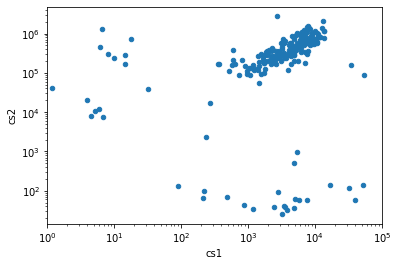

In [6]:
df = st.get_df(run_id, 'event_info',
               register=CustomPeakClassification)
df.plot.scatter('cs1', 'cs2')

import matplotlib.pyplot as plt
plt.xscale('log')
plt.xlim(1, None)
plt.yscale('log')
plt.xlim(0,1e5)
plt.show()

Compare this 'custom' with the classification with the one we have in straxen at the moment

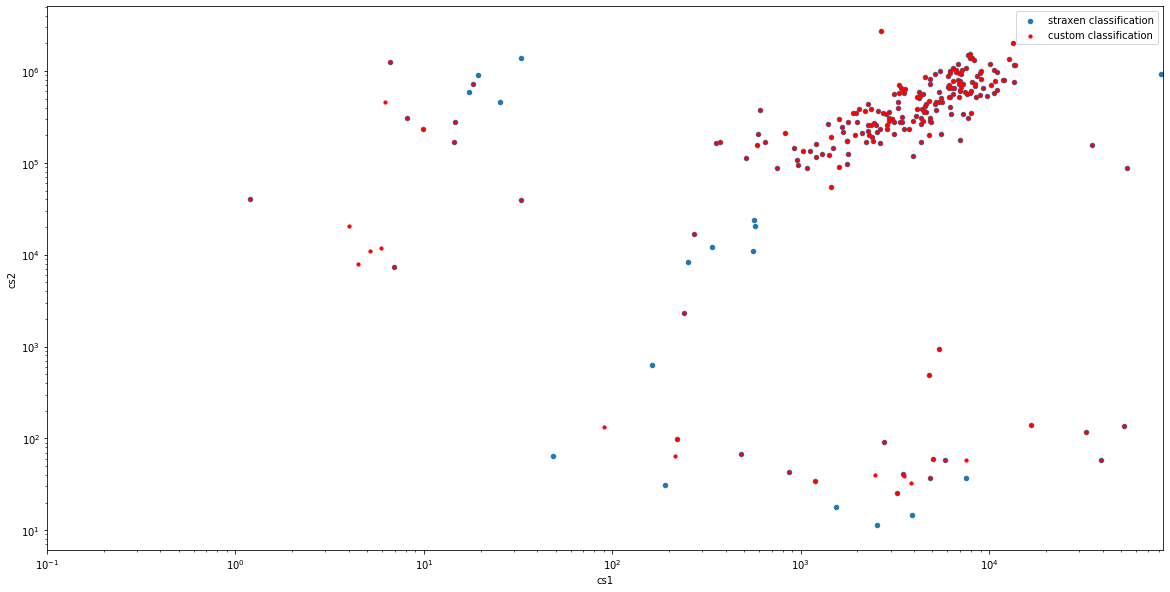

<Figure size 1440x720 with 0 Axes>

In [7]:
rcParams['figure.figsize'] = [20,10] 

df2 = st.get_df(run_id, 'event_info',)
df2.plot.scatter('cs1', 'cs2' , label = 'straxen classification')
plt.scatter(df['cs1'], df['cs2'], c= 'r', s= 10, marker = 'o', label = 'custom classification')
plt.legend(loc='best')
plt.xscale('log')
plt.xlim(0.1, None)
plt.yscale('log')
plt.figure(figsize = (20,10))
rcParams['figure.figsize'] = def_size

## Making new classification with two plugins ##

In [8]:
version = '0.0.2'
class PeakComplex(strax.Plugin):
    n_top_pmts = 127
    __version__ = version
    parallel = True
    depends_on = ('peaks',)
    provides = 'peak_complex'
    dtype = [
        (('Start time of the peak (ns since unix epoch)',
          'time'), np.int64),
        (('End time of the peak (ns since unix epoch)',
          'endtime'), np.int64),
        (('Peak integral in PE',
            'area'), np.float32),
        (('Number of PMTs contributing to the peak',
            'n_channels'), np.int16),
        (('PMT number which contributes the most PE',
            'max_pmt'), np.int16),
        (('Area of signal in the largest-contributing PMT (PE)',
            'max_pmt_area'), np.int32),
        (('Width (in ns) of the central 50% area of the peak',
            'range_50p_area'), np.float32),
        (('Fraction of area seen by the top array',
            'area_fraction_top'), np.float32),
        (('Length of the peak waveform in samples',
          'length'), np.int32),
        (('Time resolution of the peak waveform in ns',
          'dt'), np.int16),
        (('rise time of pulse [ns]',
          'rise_time'), np.float32),
        ]

    def compute(self, peaks):
        p = peaks
        r = np.zeros(len(p), self.dtype)
        for q in 'time length dt area'.split():
            r[q] = p[q]
        r['endtime'] = p['time'] + p['dt'] * p['length']
        r['n_channels'] = (p['area_per_channel'] > 0).sum(axis=1)
        r['range_50p_area'] = p['width'][:, 5]
        r['max_pmt'] = np.argmax(p['area_per_channel'], axis=1)
        r['max_pmt_area'] = np.max(p['area_per_channel'], axis=1)


        area_top = p['area_per_channel'][:, :self.n_top_pmts].sum(axis=1)
        # Negative-area peaks get 0 AFT - TODO why not NaN?
        m = p['area'] > 0
        r['area_fraction_top'][m] = area_top[m]/p['area'][m]
        r['rise_time'] = -p['area_decile_from_midpoint'][: ,1]
        return r

class ComplexPeakClassification(strax.Plugin):
    
    # Name of the data type this plugin provides
    provides = 'peak_classification'
    
    # Data types this plugin requires. Note we don't specify
    # what plugins should produce them: maybe the default PeakBasics
    # has been replaced by another AdvancedExpertBlabla plugin?
    depends_on = ('peak_complex')
    
    # Numpy datatype of the output 
    dtype = straxen.PeakClassification.dtype
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = version
    
    result = {}
    def compute(self, peaks):
        result = np.zeros(len(peaks), dtype=self.dtype)
        masks1 = (peaks['n_channels']>2) & (peaks['range_50p_area'] < 100) & (peaks['rise_time'] < 70)
        
        result['type'][masks1] = 1
        masks2 = (peaks['n_channels']>2) & (peaks['area'] > 20) & (peaks['range_50p_area'] > 100)
        result['type'][masks2] = 2

        return result


In [9]:
df_complex = st.get_df(run_id, 'event_info', register=[PeakComplex, ComplexPeakClassification])


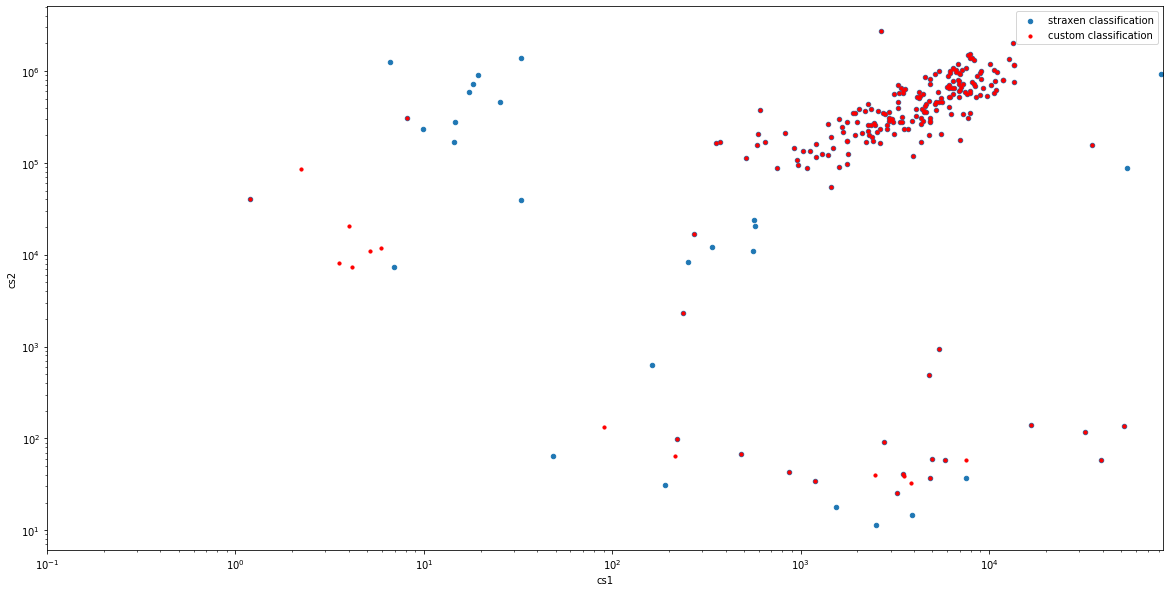

<Figure size 1440x720 with 0 Axes>

In [12]:
rcParams['figure.figsize'] = [20,10] 

df2 = st.get_df(run_id, 'event_info',)
df2.plot.scatter('cs1', 'cs2' , label = 'straxen classification')
plt.scatter(df_complex['cs1'], df_complex['cs2'], c= 'r', s= 10, marker = 'o', label = 'custom classification')
plt.legend(loc='best')
plt.xscale('log')
plt.xlim(0.1, None)
plt.yscale('log')
plt.figure(figsize = (20,10))
rcParams['figure.figsize'] = def_size